# Red-Black trees
> A love-hate affair with a data structure

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/redblacktree.png
- categories: []

In [14]:
# hide
!apt install libgraphviz-dev -qq
!pip install pygraphviz -q

libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [15]:
# hide
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import random

switch = {'left':'right','right':'left'}

class BinaryTree():
    def __init__(self, items=None, silent = False):
        self.items = 0
        self.root = None
        self.nodes = []
        self.silent = silent
        if items:
          for i in items: 
            self.ins(i) if isinstance(i,Node) else self.ins(Node(i, silent=self.silent))
    
    def change_silent(self):
      self.silent = not self.silent
      for n in self.nodes:
        n.silent=not n.silent

    def print(self, *args):
      if not self.silent: print(*args) 

    def ins(self, node):
        if not self.root:
          self.root = node
        else:
          res = self.root.ins(node)
          if res: self.root = res

        self.nodes.append(node)
        self.print('tree updated!', self, '\n')
    
    def search(self,to_search):
      cur = self.root
      while cur:
        if cur.value == to_search:
          return cur
        if to_search < cur.value:
          cur = cur.left
        else:
          cur = cur.right
      return None

    def __iter__(self):
      return iter(self.nodes)

    def __len__(self):
      return len(self.nodes)

    def __repr__(self):
        return f'Tree properties: num items = {len(self)}, root {self.root}'

    def __hash__(self):
        to_see = deque([self.root])
        seen = ''
        while to_see:
            cur = to_see.popleft()
            if cur.left: 
                to_see.append(cur.left)
            if cur.right: 
                to_see.append(cur.right)
            seen += str(cur)
        return int(seen)

    def find_leftmost(self,node):
      while node.left:
        node = node.left
      return node

    def traverse(self):
      sorted_nodes = []
      cur = self.find_leftmost(self.root)
      sorted_nodes.append(cur)
      while len(sorted_nodes) < len(self):
        if cur.right and self.find_leftmost(cur.right) not in sorted_nodes:
          cur = self.find_leftmost(cur.right)
          sorted_nodes.append(cur)
          continue
        while cur.parent and cur.parent in sorted_nodes:
          cur = cur.parent
        if cur.parent:
          cur = cur.parent
          sorted_nodes.append(cur)
      return sorted_nodes

    def draw(self):
        G = nx.DiGraph()
        for node in self.nodes:
          for direction in ['left', 'right']:
            if getattr(node, direction):
              G.add_edge(node, getattr(node, direction))
        color_map = []
        for node in G:
            if node.red:
                color_map.append('red')
            else: 
                color_map.append('grey')
        labels = {n:n.value for n in G.nodes()}
        write_dot(G,'test.dot')
        plt.figure(figsize=(13,8))
        pos = graphviz_layout(G, prog='dot')
        black_amount = {count_black(node) for node in self.nodes if not node.left or not node.left}
        any_amount = {count_black(node, black_only=False) for node in self.nodes if not node.left or not node.left}
        #print('number of items', len(self.nodes), '\nblack steps from root to leaves', black_amount)      
        fontsize=25
        nx.draw(G, pos, node_color=color_map, labels = labels,with_labels=True, node_size=1000,font_size=fontsize)
        if isinstance(self, RBTree):
          plt.title(f'RedBlack tree with {len(self.nodes)} items, {black_amount} black steps from root to all leaves',fontsize=fontsize)
        elif isinstance(self, Treap):
          plt.title(f'Treap with {len(self.nodes)} items, {any_amount}  steps from root to all leaves',fontsize=fontsize)
        else:
          plt.title(f'Binary search tree with {len(self.nodes)} items, {any_amount}  steps from root to all leaves',fontsize=fontsize)
        plt.draw()

class RBTree(BinaryTree):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
  def ins(self,*args, **kwargs):
    super().ins(*args, **kwargs)
    if len(self) == 1:
      self.root.red=False
tree = RBTree(silent=True)
class Treap(BinaryTree):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)


In [16]:
# hide
class Node():
  
  
    def __init__(self, value, parent = None, left = None, right = None, red = True, silent = False):
        self.parent, self.left, self.right, self.value, self.red, self.silent = parent, left, right, value, red, silent

    def print(self, *args):
      if not self.silent: print(*args) 

    def set_child(self, direction, child):
      setattr(self, direction, child)
      if child:
        child.parent = self

    def switch(self):
        self.red = not self.red

    def get_sibling(self):
      if self.get_dir_from_parent():
        return getattr(self.parent, switch[self.get_dir_from_parent()])
      else:
        self.print(self, 'no parent!')

    def get_uncle(self):
        return self.parent.get_sibling()

    def get_dir_from_parent(self):
      if self.parent:
        if self.parent.left == self:
          return 'left'
        else:
          return 'right'
      else:
        self.print(self, 'no parent!')

    def __eq__(self, other):
        return True if other and self.value == other.value else False

    def __gt__(self,other):
        return self.value > other.value
    
    def __ge__(self,other):
        return self.value >= other.value

    def __str__(self):
        # return str(id(self)) # for doubles in networkx
        return str(self.value)

    def __repr__(self):
        return f'{self.value}'
    def __hash__(self):
        return id(self)

    def ins(self, new):
      self.print(self)
      def ins_direction(dir):
        self.print(dir)
        if getattr(self,dir) == None:
          self.set_child(dir,new)
          return self.check(new, dir)
        else:
          return getattr(self, dir).ins(new)
      if new < self:
        return ins_direction('left')
      else:
        return ins_direction('right')

    def check(self, child, direction):
        self.print('checking', self, child, direction)
        if not self.parent:
          self.print('root has been checked, was red = ',self.red)
          self.red = False
          return self

        if child.red and self.red: # otherwise there is no violation 
            parent = self
            grandparent = self.parent
            rootchange = None
            if getattr(grandparent, direction) == self: 
                line = True
                uncle = getattr(grandparent, switch[direction])
            else:
                line = False
                uncle = getattr(grandparent, direction)
            self.print(f'Violation! child {child}, parent{parent}, grandparent {grandparent}, uncle {uncle}')

            # now we check if its case 1, 2 or 3
            if uncle and uncle.red: # case 1, recolor
                self.print('Violation type: recolor')
                for entity in [uncle, parent, grandparent]:
                    entity.switch()
                if grandparent:
                  self.print('extra check', grandparent)
                  return grandparent.check(parent, parent.get_dir_from_parent())
            
            elif not uncle or not uncle.red: 
                if line: # case 2, line
                    self.print('Violation type: line', direction)
                    # right rotation on G
                    rootchange = grandparent.rotate(switch[direction])
                    if grandparent:
                      grandparent.switch()
                    parent.switch()
                else: # case 3, triangle, left rotation on Parent
                    self.print('Violation type: triangle', direction)
                    self.rotate(switch[direction])
                    return child.check(parent, switch[direction])
            self.print('return' ,rootchange)        
            return rootchange
        elif self.parent: 
          self.print('do another check self', self, 'parent' ,self.parent)
          return self.parent.check(self, self.get_dir_from_parent())

    def rotate(self, direction):
        parent = self
        grandparent = self.parent
        child = getattr(self,switch[direction])
        self.print('ROTATE',direction, 'gp',grandparent, 'p',parent, 'c',child)
        # if hasattr(child,direction):
        parent.set_child(switch[direction],getattr(child,direction))
        # else:
        # parent.set_child(switch[direction],None)

        if grandparent:
          grandparent.set_child(parent.get_dir_from_parent(), child)
        else:
          child.parent = None
          self.print("ROOTCHANGE")
          child.set_child(direction, parent)
          return child
        child.set_child(direction, parent)
        return
    def get_children(self):
      return [n for n in [self.left,self.right] if n]
    

In [17]:
# hide
def count_black(node, black_only = True):
  cur = node
  count = 1
  while cur.parent:
    if black_only:
      if not cur.red: count+=1
    else:
      count+=1
    cur = cur.parent
  return count
  
def is_valid_tree(tree):
  if len(tree) == 0:
    assert tree.root == None
  else:
    assert tree.root.parent is None
    assert tree.root.red == False
    for node in tree:
      if node.parent:
        assert node == getattr(node.parent, node.get_dir_from_parent())
      if node.red: # all red nodes dont have red children
        assert node.left == None or node.left.red == False
        assert node.right == None or node.right.red == False
      if node.left:
        assert node.left <= node
      if node.right:
        assert node.right >= node
    # number of black steps
    # all ends of the tree traverse the same amount of black nodes before ending at root
    black_amount = {count_black(node) for node in tree if not node.left or not node.left} 
    assert len(black_amount) == 1

is_valid_tree(RBTree())
is_valid_tree(RBTree((8, 5, 12, 19, 13, 9, 23, 10),silent=True))
is_valid_tree(RBTree(list(range(30)),silent=True))
is_valid_tree(RBTree(reversed(list(range(200))),silent=True))
out = [Node(i) for i in [5, 8, 9, 10, 12, 13, 19, 23]]
assert RBTree((8,5, 12, 19, 9, 23, 10,13),silent=True).traverse() == out

In [18]:
# hide
def remove(self, value):
  node = self.search(value)
  if node.right:
    to_delete = self.find_leftmost(node.right)
  else: # node.left or node has no children
    to_delete = node
  self.print(f'original {node.value}, to delete {to_delete.value}')


  if not to_delete.red: # only black cases are difficult and need specific action
    # determine child
    to_delete_child = to_delete.get_children()[0] if to_delete.get_children() else None 
    self.print('to_delete is black',to_delete, 'child value', to_delete_child)
    if not to_delete_child:
      self.print('child is black (None), doubleblack time',to_delete)
      self.fix_doubleblack(to_delete)
    else:
      if to_delete_child.red:
        self.print('child is red')
        to_delete.parent.set_child(to_delete.get_dir_from_parent(),to_delete_child)
        self.print(f'just set{to_delete.parent} to {to_delete_child.parent} {to_delete_child.parent.left} {to_delete_child.parent.right}')
        to_delete_child.red = False
      else:
        self.print('doubleblack time',to_delete)
        # to_delete.parent.set_child('left',to_delete_child)
        self.fix_doubleblack(to_delete_child)
        
  self.nodes.remove(to_delete)
  node.value = to_delete.value # for some reason this needs to happen after self is removed from nodes
  del to_delete
  self.print('final node value', node.value)
  is_valid_tree(self)
  return

def fix_doubleblack(self,to_delete):
  self.print('doubleblack boys',to_delete.value)
  sib_red = True if to_delete.get_sibling() and to_delete.get_sibling().red else False 
  par_red = True if to_delete.parent and to_delete.parent.red else False
  dir_from_parent = to_delete.get_dir_from_parent()
  self.print('samedirection', dir_from_parent)

  sib_same_red = True if to_delete.get_sibling() and to_delete.get_sibling().left and to_delete.get_sibling().left.red else False
  sib_other_red = True if to_delete.get_sibling() and to_delete.get_sibling().right and to_delete.get_sibling().right.red else False
  if dir_from_parent == 'right':
    sib_same_red, sib_other_red = sib_other_red, sib_same_red  

  #case 1
  if not to_delete.parent:
    self.print('case1')
    return # terminal case

  #case 2
  elif sib_red:
    self.print('case2')
    to_delete.parent.red = True
    to_delete.get_sibling().red = False
    root = to_delete.parent.rotate(dir_from_parent)
    if root: self.root = root
    return self.fix_doubleblack(to_delete)

  #case 3
  elif not par_red and not sib_red and not sib_same_red and not sib_other_red:
    self.print('case3')
    to_delete.get_sibling().red = True
    return self.fix_doubleblack(to_delete.parent)
  
  #case 4
  elif par_red and not sib_red and not sib_same_red and not sib_other_red:
    self.print('case4')
    to_delete.parent.red = False
    to_delete.get_sibling().red = True
    return # terminal case

  #case 5
  elif not sib_red and sib_same_red and not sib_other_red:
    self.print('case5')
    # exchange colors of S and new P
    to_delete.get_sibling().red = True
    getattr(to_delete.get_sibling(), dir_from_parent).red = False
    to_delete.get_sibling().rotate(switch[dir_from_parent])
    return self.fix_doubleblack(to_delete) # should result in case 6

  #case 6
  elif not sib_red and sib_other_red:
    self.print('case6')
    # exchange colors of P and S, and make Srchild black
    to_delete.parent.red, to_delete.get_sibling().red = to_delete.get_sibling().red, to_delete.parent.red
    getattr(to_delete.get_sibling(), switch[dir_from_parent]).red = False
    # rotate left at P
    to_delete.parent.rotate(dir_from_parent)
    return # terminal case

  else:
    self.print('something wrong, no case?', to_delete, to_delete.parent, to_delete.right, to_delete.right)
  return

RBTree.remove = remove
RBTree.fix_doubleblack = fix_doubleblack

for i in list(range(0,30,2))+[17,25,27]:
  tree = RBTree(list(range(0,30,2))+[17,25,27],silent=True)
  tree.remove(i)
  is_valid_tree(tree)

After playing around with red-black trees for some time, I’ve grown to really like them, but also hate them at the same time! I'll explain in this blog why. To understand what a red-black tree is, we’ll first have to touch upon the concept of a binary search tree. The binary search tree is a method of ordering items that can be compared to each other. The easiest example is of course numbers (1 < 2), other object such as letters (a < b) or words (short < longerword) can also be compared.

A binary tree is very simple and I had fun making one with my six year old daughter. She came up with a list of numbers and together we added them to the tree. The root of the tree is the first item you start with. Next, to add another item you simply check if the item is smaller or larger than the root. If it’s smaller it gets stored into the left branch, if it’s larger it goes to the right branch. A node in the tree can have only one branch on each side. Therefore the tree will have to get deeper when more nodes are added. As an example, a tree with 3 layers holds a maximum of 1+2+4 = 7 nodes. Below an example, where it takes three steps to reach 5,14 and 55 and four steps to reach 62 and 66. These nodes are the edge of the tree and are called leaves.

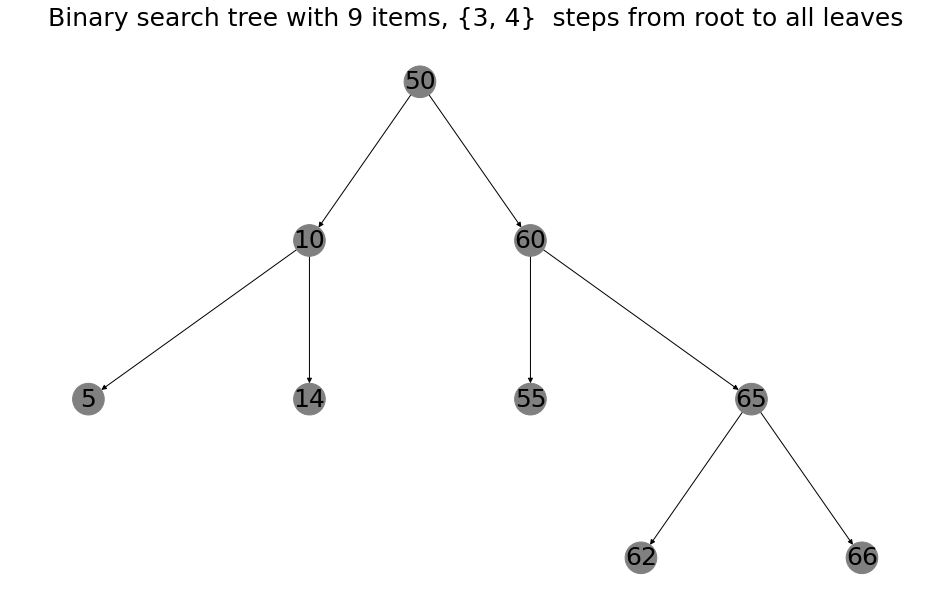

In [19]:
#hide_input
class BinNode(Node):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.prio = random.random()
    self.red = False

  def check(self, child, direction):
    return
    
tree = BinaryTree(silent=True)
l = [50,10,60,5,14,65,55,66,62]
for i in l:
  tree.ins(BinNode(i, silent=True))
tree.draw(
)

The advantage of binary search trees is that the items are ordered. For example, you can easily lookup the minimum (just always go left from the root). But also finding an item can be very quick, which is expressed by the number of steps from the root. It makes sense, if you are interested in the left side of the tree, you no longer need to search the right side.

But think about a scenario where you insert numbers in order, ascending. The tree would only have right branches! This effectively means you are just storing a list. Now for a small tree (as the one below), that is no problem, but if you are storing a million items this way, you would have to search a million items before inserting the next number. If the tree would have been balanced, it would only take about 20 steps from the root to any leaf (1 million log base 2).

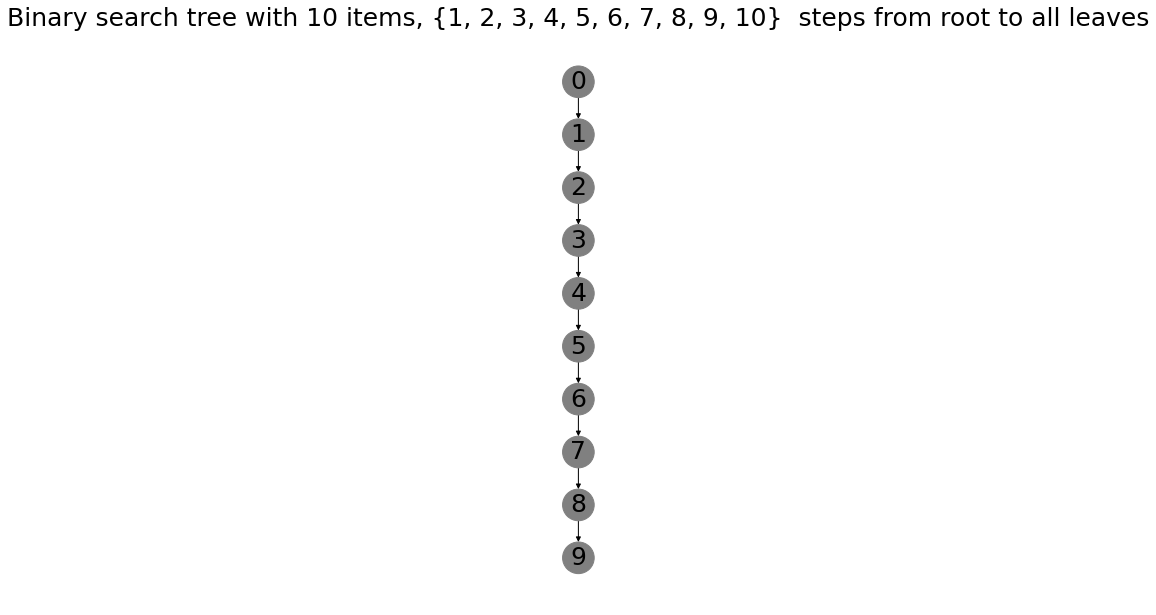

In [20]:
#hide_input
tree = BinaryTree(silent=True)
l = list(range(10))
for i in l:
  tree.ins(BinNode(i, silent=True))
tree.draw(
)

This is where red-black trees come in. They are self-balancing to solve the above problem. In a red-black tree, items are colored in two colors. You’ve guessed it, red or black. There are a couple of rules:

* The root is always black
* While going from root to any leaf, you’ll never pass two consecutive red items
* The amount of black items you pass while going to an end of the tree is the same for each leaf of the tree.

To preserve these properties insertion and removal can require certain operations, such as recoloring certain items, or rotating part of the tree. And this is where my love and hate comes in. It’s awesome to see the different shapes the tree can take while balancing. Even the root of the tree can change in the process. A couple of examples:

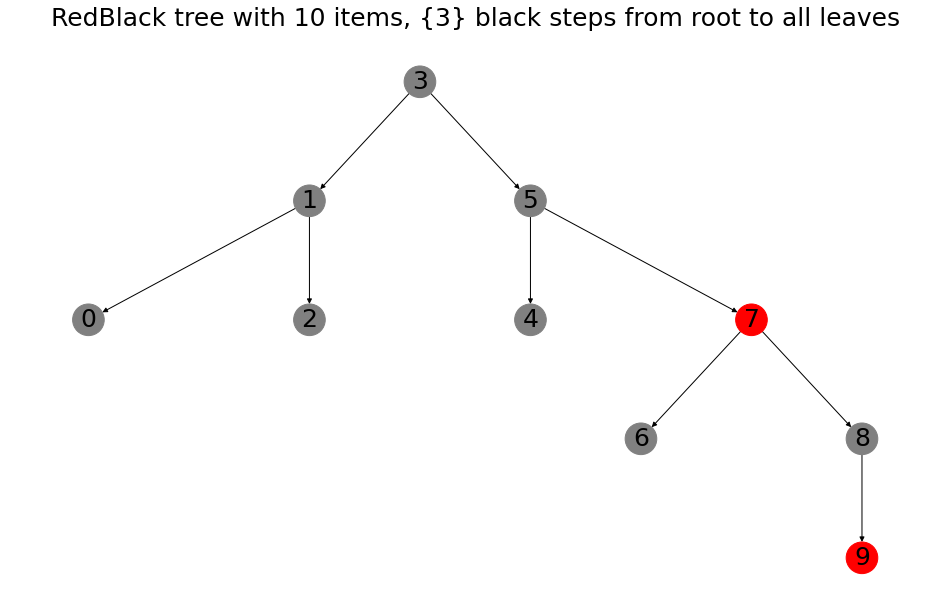

In [21]:
#hide_input
RBTree(list(range(0,10)),silent=True).draw()

In the above figure, numbers 0 to 10 were inserted in order. The graph shows that the redblack tree has been rotated to now have 3 as root (no longer the 0 it started with initially). Also the paths from the root (3) to the leaves (0,2,4,6,8 and 9) all cross exactly 3 black nodes!

If we insert 50 items in order, a nice balanced tree appears

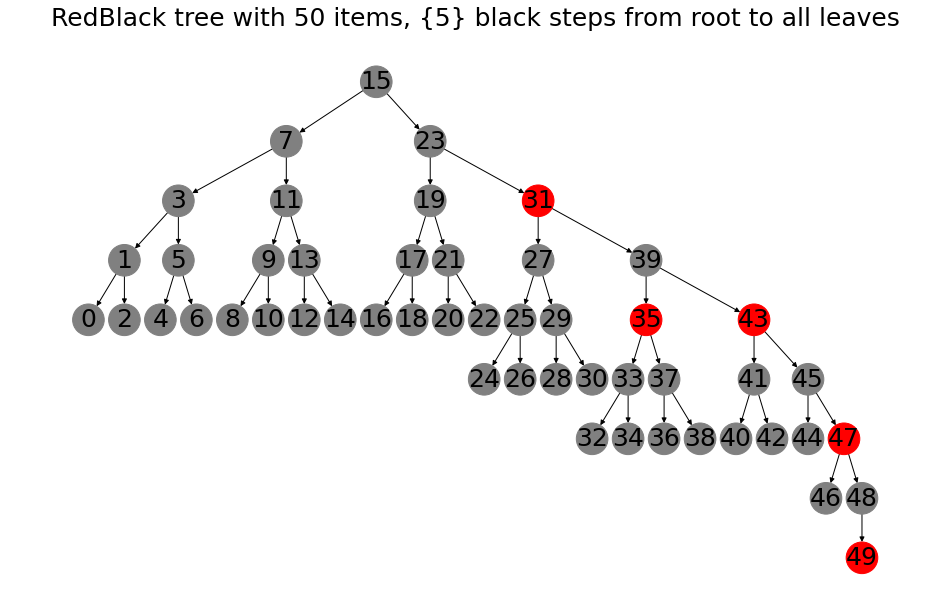

In [22]:
to_insert = list(range(50))
RBTree(to_insert,silent=True).draw()

When we randomize the insertion order a completely different tree arises, but still it's nicely balanced.

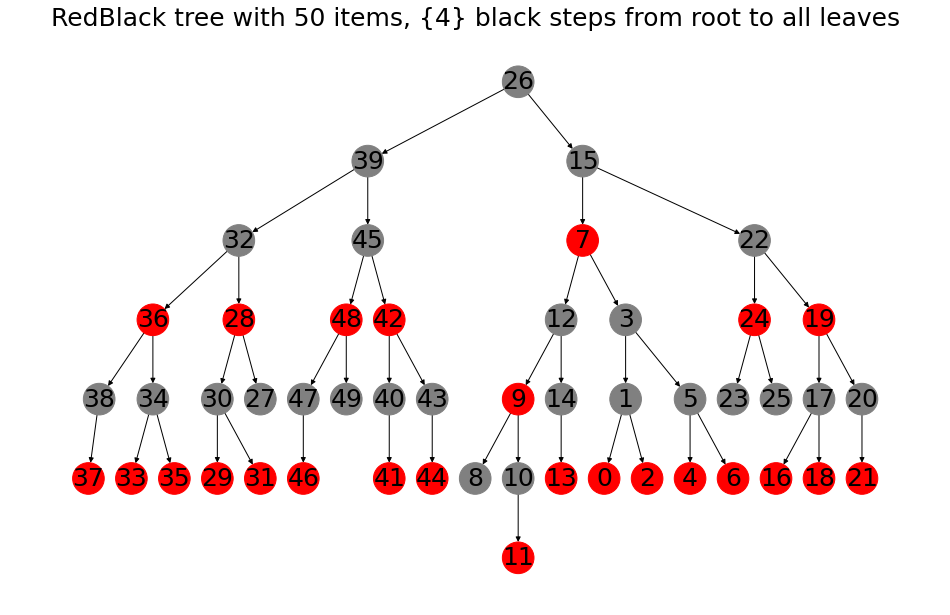

In [23]:
random.shuffle(to_insert)
RBTree(to_insert,silent=True).draw()

I think this looks elegant. However, it’s known that redblack trees can be difficult to implement and indeed it's been an absolute pain to code the algorithms, with some difficult debugging to take care of all the edge cases to make sure the code runs correctly. More detailes of all the cases you can encounter at [Wikipedia](https://en.wikipedia.org/wiki/Red%E2%80%93black_tree#Operations). I’ve gained new appreciation for programming concepts such as unit testing, refactoring, and plain old careful reading of the specification. Seeing it work has made this project worth it!

After some [reading](https://web.archive.org/web/20140327140251/http://www.cepis.org/upgrade/files/full-2004-V.pdf), I’ve also come across the treap (tree-heap), which is basically using random numbers to make the tree structure as if the items would have been inserted in random order. Which will make the tree balanced with a high probablility. 

To illustrate the randomness, I've twice made a treap with 50 items inserted in order. The resulting trees are different, which does not happen with red-black trees when the insertion order is the same. Treaps look much different then the red-black trees as well.

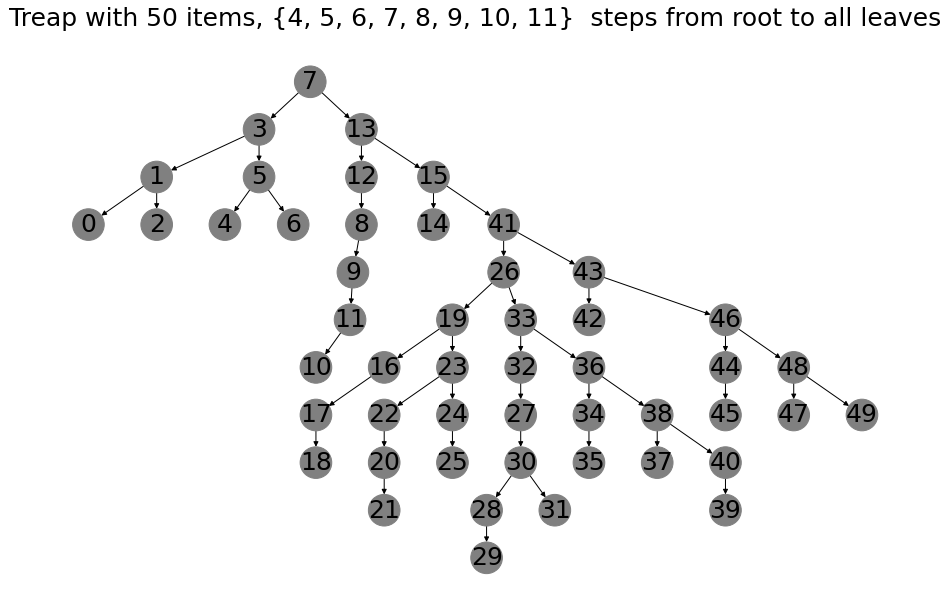

In [24]:
#hide_input
class TreapNode(Node):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.prio = random.random()
    self.red = False

  def check(self, child, direction):
    self.print('checking', self, child, direction)
    if child.prio > self.prio:
      # print('priority of child higher than parent')
      self.rotate(switch[direction]) # or switch[direction]
      if child.parent is None:
        return child
      return child.parent.check(child, child.get_dir_from_parent())

tree = Treap(silent=True)
for i in range(50):
  tree.ins(TreapNode(i, silent=True))
tree.draw(
)

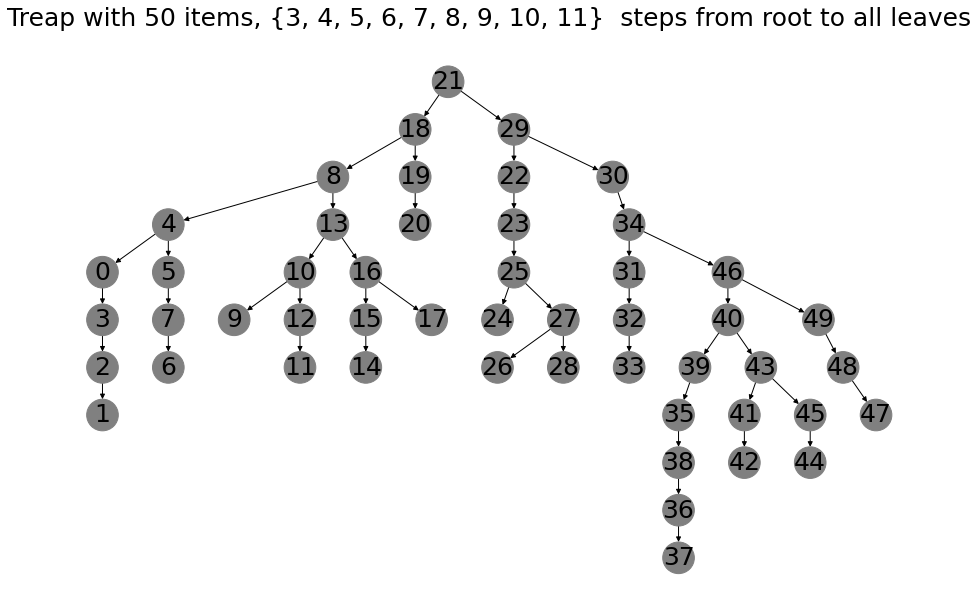

In [25]:
#hide_input
tree = Treap(silent=True)
for i in range(50):
  tree.ins(TreapNode(i, silent=True))
tree.draw(
)

Treaps are much simpler to implement and outperform red-black trees on insertion, search and deletion, but due to their randomized nature are less consistent. Also red-black trees look nicer in my opinion.

That's it, hope you enjoyed it this exploration of trees!

> Tip: [This page](https://people.ksp.sk/~kuko/gnarley-trees/Redblack.html) has a nice animation how red-black trees are build. Additionally, Wikipedia has more information about  [binary search trees](https://en.wikipedia.org/wiki/Binary_search_tree), [red black trees](https://en.wikipedia.org/wiki/Red%E2%80%93black_tree) and [treaps](https://en.wikipedia.org/wiki/Treap)
